In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay
import pickle
from sklearn.preprocessing import normalize

In [2]:
# baseline of accuracy in the datasets
df = pd.read_csv('../data/Loan_Default.csv')
df.drop(columns=['ID','year','Interest_rate_spread','Upfront_charges','rate_of_interest'],inplace=True)
df = df.sample(20000,random_state=42)
X = df.drop(columns='Status')
y = df['Status']
most_frequent_class = y.mode()[0]
value_counts = y.value_counts(normalize=True)
baseline_accuracy = value_counts[most_frequent_class]
print(f"Baseline of accuracy score: {baseline_accuracy:.4}")

Baseline of accuracy score: 0.7606


In [ ]:
paths = ['../results/reduced_feature_logistic.save', '../results/reduced_feature_SVM.save','../results/reduced_feature_KNN.save', '../results/reduced_feature_random_forest.save']
model_names = ['Logistic Regression', 'Support Vector Classifier', 'KNeighbors Classifier', 'Random Forest Clasifier']

# record the perfomance of each ML algorithm
accs_record = []
confusion_matrices_record = []


In [4]:
def get_score(y_preds, test_sets, model_name):
    accs = []
    f1s = []
    recalls = []
    precisions = []
    confusion_matrices = []
    for y_pred,test_set in zip(y_preds,test_sets):
        _,y_test = test_set
        order_y_test = y_test.sort_index()
        accs.append(accuracy_score(order_y_test,y_pred))
        f1s.append(f1_score(order_y_test,y_pred))
        recalls.append(recall_score(order_y_test,y_pred))
        precisions.append(precision_score(order_y_test,y_pred))
        confusion_matrices.append(confusion_matrix(order_y_test,y_pred))
    accs_record.append(accs)
    print(model_name)
    print(f"mean of accuracy score: {np.mean(accs)},    standard deviation of accuracy score: {np.std(accs)}")
    print(f"mean of f1 score: {np.mean(f1s)},     standard deviation of f1 score: {np.std(f1s)}")
    print(f"mean of recall score: {np.mean(recalls)},     standard deviation of recall score: {np.std(recalls)}")
    print(f"mean of precision score: {np.mean(precisions)},     standard deviation of precision score: {np.std(precisions)}")
    print('*' * 50)
    confusion_matrix_avg = np.sum([confusion_matrices[0] , 
                                confusion_matrices[1], 
                                confusion_matrices[2],
                                confusion_matrices[3],
                                confusion_matrices[4]], axis = 0)/5
    confusion_matrices_record.append(confusion_matrix_avg)

In [5]:
for i in range(4):
    file = open(paths[i], 'rb')
    y_preds, models, test_sets, unique_rows_record = pickle.load(file)
    file.close()
    get_score(y_preds, test_sets, model_names[i])

Logistic Regression
mean of accuracy score: 0.867,    standard deviation of accuracy score: 0.003297726489568227
mean of f1 score: 0.6485620262538616,     standard deviation of f1 score: 0.01024923815573843
mean of recall score: 0.49847715736040604,     standard deviation of recall score: 0.010686454714266628
mean of precision score: 0.9282173923296865,     standard deviation of precision score: 0.01092101490573547
**************************************************
Support Vector Classifier
mean of accuracy score: 0.87095,    standard deviation of accuracy score: 0.002722131517763224
mean of f1 score: 0.6476387776509693,     standard deviation of f1 score: 0.014606555601158469
mean of recall score: 0.4958246346555324,     standard deviation of recall score: 0.021084561457958416
mean of precision score: 0.9356563167149927,     standard deviation of precision score: 0.017158288193164502
**************************************************
KNeighbors Classifier
mean of accuracy score: 0.857

In [6]:
# XGBoost
file = open('../result/XGB_grid.save', 'rb')
test_sets, best_models = pickle.load(file)
file.close()

accs = []
f1s = []
recalls = []
precisions = []
confusion_matrices = []
for test_set,best_model in zip(test_sets, best_models):
    X_test,y_test = test_set
    y_pred = best_model.predict(X_test)
    accs.append(accuracy_score(y_test,y_pred))
    f1s.append(f1_score(y_test,y_pred))
    recalls.append(recall_score(y_test,y_pred))
    precisions.append(precision_score(y_test,y_pred))
    confusion_matrices.append(confusion_matrix(y_test,y_pred))
accs_record.append(accs)
model_names.append('XGBoost Classifier')
print('XGBoost Classifier')
print(f"mean of accuracy score: {np.mean(accs)},    standard deviation of accuracy score: {np.std(accs)}")
print(f"mean of f1 score: {np.mean(f1s)},     standard deviation of f1 score: {np.std(f1s)}")
print(f"mean of recall score: {np.mean(recalls)},     standard deviation of recall score: {np.std(recalls)}")
print(f"mean of precision score: {np.mean(precisions)},     standard deviation of precision score: {np.std(precisions)}")

confusion_matrix_avg = np.sum([confusion_matrices[0] , 
                                confusion_matrices[1], 
                                confusion_matrices[2],
                                confusion_matrices[3],
                                confusion_matrices[4]], axis = 0)/5
confusion_matrices_record.append(confusion_matrix_avg)

XGBoost Classifier
mean of accuracy score: 0.8910499999999999,    standard deviation of accuracy score: 0.0055213223053902595
mean of f1 score: 0.7244852945105255,     standard deviation of f1 score: 0.009876293233095022
mean of recall score: 0.6029835436984258,     standard deviation of recall score: 0.011184189049760816
mean of precision score: 0.9075600317708897,     standard deviation of precision score: 0.013944264111577903


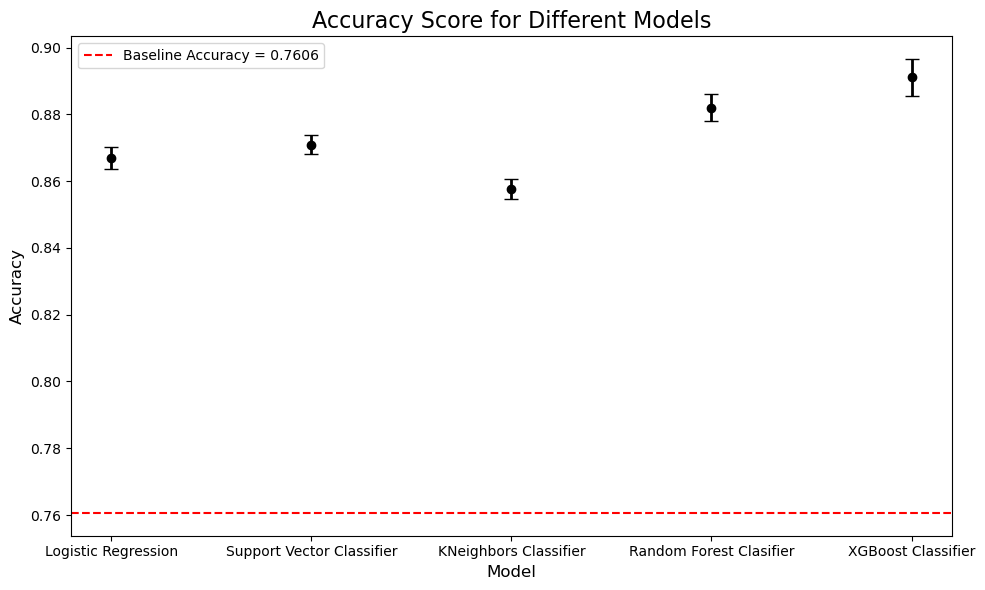

In [7]:
plt.figure(figsize=(10, 6))
plt.errorbar(model_names, [np.mean(acc) for acc in accs_record], yerr=[np.std(acc) for acc in accs_record], fmt='o', color='black', capsize=5, elinewidth=2)
plt.axhline(baseline_accuracy, color='red', linestyle='--', label=f'Baseline Accuracy = {baseline_accuracy}')
plt.title('Accuracy Score for Different Models', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('Accuracy Score for Different Models.png', bbox_inches='tight', dpi=400)
plt.show()


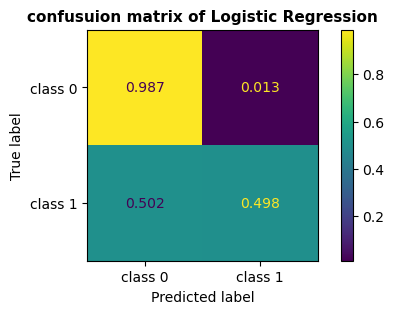

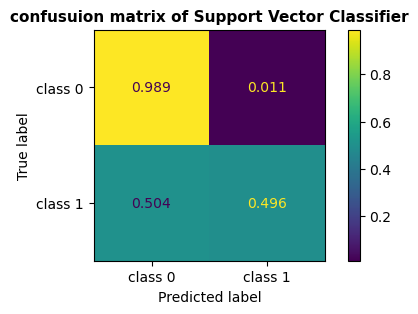

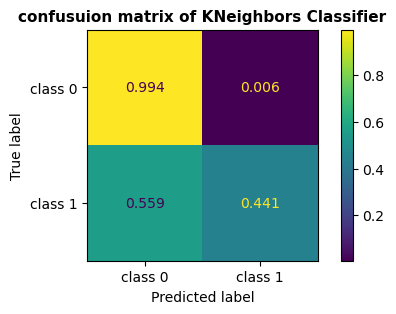

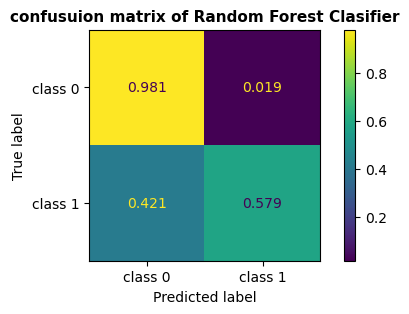

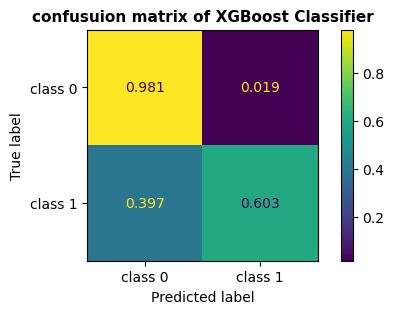

In [8]:
confusion_matrices_record = [normalize(confusion_matrix, axis=1, norm='l1') for confusion_matrix in confusion_matrices_record]
for i in range(5):
    disp = ConfusionMatrixDisplay(confusion_matrices_record[i],display_labels=['class 0', 'class 1'])
    fig, ax = plt.subplots(figsize=(6,3))
    disp.plot(ax=ax, values_format='.3f')
    plt.title(f'confusuion matrix of {model_names[i]}', fontsize=11, fontweight='bold')
    plt.savefig(f'confusuion matrix of {model_names[i]}.png', bbox_inches='tight', dpi=400)
    plt.show()